In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('./fer2013.csv')

width, height = 48, 48

datapoints = data['pixels'].tolist()


X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)


y = pd.get_dummies(data['emotion']).to_numpy()


np.save('fdataX', X)
np.save('flabels', y)

print("Preprocessing Done")
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))

Preprocessing Done
Number of Labels: 7
Number of examples in dataset:35887


Using TensorFlow backend.


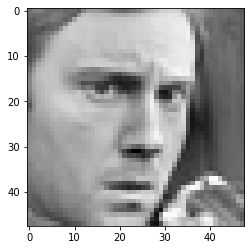

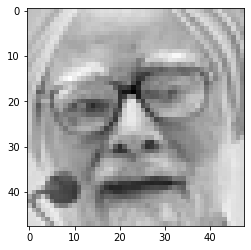

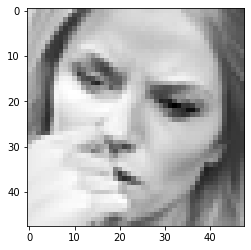

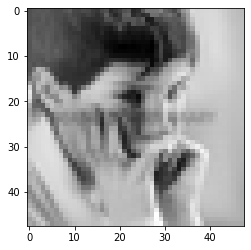

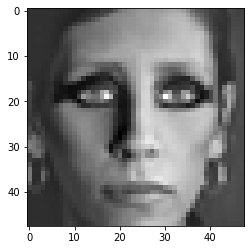

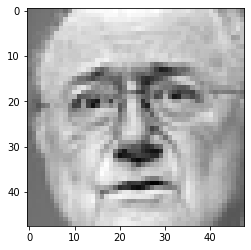

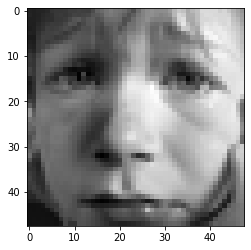

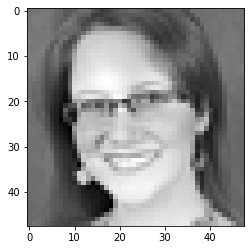

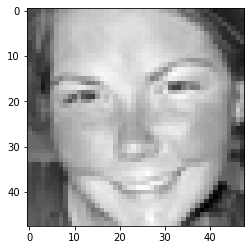

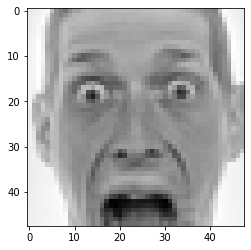

In [2]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json


num_labels = 7
batch_size = 64
epochs = 100

x = np.load('./fdataX.npy')
y = np.load('./flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

for xx in range(10):
    plt.figure(xx)
    plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)
np.save('modXtest', X_test)
np.save('modytest', y_test)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)      

In [5]:
#Compliling
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
#training 
model.fit(np.array(X_train), np.array(y_train),
          batch_size=64,
          epochs=100,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

Train on 29068 samples, validate on 3230 samples
Epoch 1/100
  448/29068 [..............................] - ETA: 20:27 - loss: 4.4002 - accuracy: 0.1763

In [6]:
#saving the  model to be used later
fer_json = model.to_json()
with open("fer_01.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer_01.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import os
import numpy as np

json_file = open('fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

truey=[]
predy=[]
x = np.load('./modXtest.npy')
y = np.load('./modytest.npy')

yhat= loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100
print("Accuracy on test set :"+str(acc)+"%")

Loaded model from disk
Accuracy on test set :66.36946224575091%


In [10]:
#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")

Predicted and true label values saved
Accuracy on test set :66.36946224575091%


[[291   6  49  22  72   9  49]
 [ 11  33   3   2   2   1   0]
 [ 47   7 283  21  95  45  47]
 [ 22   0  18 751  30  14  46]
 [ 59   1  69  29 346   1  83]
 [ 11   0  54  31   4 301  13]
 [ 39   1  37  51  95  11 377]]


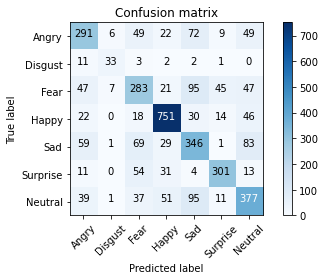

In [13]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = np.load('./truey.npy')
y_pred = np.load('./predy.npy')
cm = confusion_matrix(y_true, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [2]:
import cv2
cam = cv2.VideoCapture(0)
cv2.namedWindow("test")
img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.jpg".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

opencv_frame_0.jpg written!
Escape hit, closing...


In [1]:
# load json and create model
from __future__ import division
from keras.models import model_from_json
import os
import numpy as np
import cv2
import sys

#loading the model
json_file = open('fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [ ]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#loading image
full_size_image = cv2.imread("opencv_frame_0.jpg")
print("Image Loaded")
gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face.detectMultiScale(gray, 1.3  , 10)

#detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        yhat= loaded_model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)
        print("Emotion: "+labels[int(np.argmax(yhat))])

cv2.imshow('Emotion', full_size_image)
cv2.waitKey()


Image Loaded
